# Discriminative Estimators

Discriminative estimators are mutual information estimators based on the Donsker-Varadhan representation of the KL divergence that describes mutual information:

$$
I(x;y) = KL(p(x,y)||p(x)p(y)) \ge \max_{F\in\mathcal{F}} \mathbb{E}_{p(x,y)}[F(x,y)] -\log\mathbb{E}_{p(x)p(y)}[e^{F(x,y)}],
$$

Mutual information estimators in literature differ in the modeling choice and optimization strategy for the *energy* $F(x,y)$, and in the method used to estimate the expectations above.


In order to showcase the different modeling choices, we will estimate mutual information between samples from a 2D  mixture of correlated Normals $p(x,y):=\sum_{i=1}^K \pi_i\ \mathcal{N}([x_i, y_i]^T|\mu_i,\Sigma_i)$, which is challenging enough to underline some effect of the modeling choices.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
IMG_SIZE=3

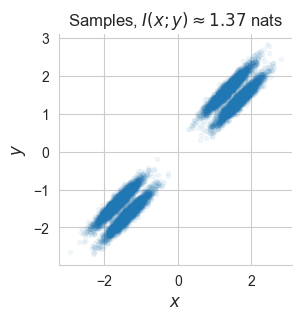

In [3]:
from torch_mist.data.multimixture import MultivariateCorrelatedNormalMixture

# Definition of the distribution
x_dim = y_dim = n_dim = 1
p_XY = MultivariateCorrelatedNormalMixture(n_dim=n_dim)

true_mi = p_XY.mutual_information('x','y')

# Generate 100000 samples
samples = p_XY.sample([100000])

# Plot them
f, ax = plt.subplots(1,1, figsize=(IMG_SIZE, IMG_SIZE))

plt.scatter(
    samples['x'][::10], samples['y'][::10],
    marker='.',
    alpha=0.05
)
sns.despine()
plt.title(f"Samples, $I(x;y)\\approx {np.round(true_mi,2)}$ nats")
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12);

In [4]:
# We define the training parameters

train_parameters = dict(
    max_epochs=10,
    batch_size= 128,
    verbose=True,
    valid_percentage=0,
    lr_annealing=True,
)

## Estimating the log-partition function

One of the central challenges in the computation of mutual information lies in the estimation of the expected log-partition function $\log\mathbb{E}_{p(x)p(y)}[e^{F(x,y)}]$.
Since the logarithm occurs outside the expectation w.r.t. $p(x)p(y)$, any naive batch-based estimation would result in a biased estimate.

To prevent this, it is possible to use the inequality $\log a \le a - 1$ to define an upper-bound that is tight for $\log a = 1$:



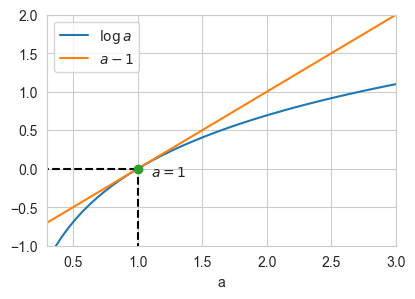

In [5]:
a = np.linspace(0.3, 3)

f, ax = plt.subplots(1,1,figsize=(IMG_SIZE*1.5, IMG_SIZE))
ax.set_xlim(0.3,3)
ax.set_ylim(-1,2)
ax.set_xlabel('a')


# Original value
plt.plot(a, np.log(a), label='$\\log a$')

# Upper-bound
plt.plot(a, a-1, label='$a - 1$')
plt.legend()

plt.plot([0, 1],[0,0], ls='--', color='k')
plt.plot([1, 1],[-1.5,0], ls='--', color='k')
plt.plot(1, 0, 'o')
plt.text(1+0.1, -0.1, '$a = 1$');

This can be applied to the previous equation as follows:
$$
\log\underbrace{\mathbb{E}_{p(x)p(y)}[e^{F(x,y)}]}_{a} \le \mathbb{E}_{p(x)p(y)}[e^{F(x,y)}]-1 
$$
The resulting expectation, can be approximated with a batch of $N$ iid samples $(x_i,y_i)\stackrel{N}{\sim} p(x,y)$:
$$
\mathbb{E}_{p(x)p(y)}\left[e^{F(x,y)}\right] \approx \frac{1}{NM}\sum_{i=1}^N\sum_{j=1}^M e^{F(x_i,y_{(i+j)\mod N})}
$$
in which $(i+j)\mod{N}$ is used to select the first $M$ elements in the batch starting from $i+1$, looping around for $i+j>N$. This is because the pair $(x_i,y_j)$ for $i\neq j$ can be considered as a sample from $p(x)p(y)$.

## Energy parametrizations

Several discriminative estimators in literature can be interpreted by considering different parametrizations of energy function, which trade-off several aspects such as tightness of the bound and variance off the log-partition function. All parametrization make use of a neural network architecture $f_\theta(x,y)$ which is referred to as `critic`.
In particular, the energy can be expressed as a difference between the `critic` $f_\theta(x,y)$ and a `baseline` $b(x)$:
$$
F(x,y) = f_\theta(x,y) - b(x)
$$

Here we report a table for the most popular baseline choices

| Model     | Baseline $b(x)$                                                                   |
|-----------|-----------------------------------------------------------------------------------|
| NWJ       | $1$                                                                               |
| MINE$^*$  | $\log\mathbb{E}_{p(x)p(y)}\left[e^{f_\theta(x,y)}\right]$                         | 
| InfoNCE   | $\log\mathbb{E}_{p(y)}\left[e^{f_\theta(x,y)}\right]$                             |
| TUBA      | $MLP_\psi(x)$                                                                     | 
| AlphaTuba | $\alpha\log\mathbb{E}_{p(y)}\left[e^{f_\theta(x,y)}\right]+(1-\alpha)MLP_\psi(x)$ |
in which $^*$ is used to specify that the MINE estimator uses a different baseline for training, and $MLP_\psi(x)$ refers to a Multi-Layer Perceptron with parameters $\psi$.

`torch_mist` includes implementations of the aforementioned estimators, but different baselines can also be instantiated explicitly.


In [6]:
from torch_mist.baseline import ConstantBaseline, ExponentialMovingAverage, baseline_nn, InterpolatedBaseline

# some example baselines
baselines = {
    'Constant': ConstantBaseline(1),                        # NWJ baseline
    'EMA': ExponentialMovingAverage(gamma=0.9),             # MINE baseline (training)
    'Learnable': baseline_nn(                               # TUBA baseline
        x_dim=x_dim,
        hidden_dims=[32, 32],    
    ),
    'Interpolated': InterpolatedBaseline(                   # Custom interpolated baseline 
        baseline_1=ExponentialMovingAverage(gamma=0.9),     # alpha * EMA +
        baseline_2=baseline_nn(                             # (1-alpha) * LearnableBaseline(x)
            x_dim=x_dim,
            hidden_dims=[32, 32],    
        ),
        alpha=0.5
    )
}

for name, baseline in baselines.items():
    n_params = sum([param.numel() for param in baseline.parameters()])
    print(f"{name} baseline, {n_params} Parameters")

Constant baseline, 0 Parameters
EMA baseline, 0 Parameters
Learnable baseline, 1153 Parameters
Interpolated baseline, 1153 Parameters


In [7]:
from torch_mist.estimators.discriminative import BaselineDiscriminativeMIEstimator
from torch_mist.critic import joint_critic
from copy import deepcopy
from torch_mist.utils import train_mi_estimator


pd_log = pd.DataFrame()

# We instantiate a simple critic architecture
critic = joint_critic(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=[64, 64],
)

# We can train all the estimators using the same critic
for name, baseline in baselines.items():
    estimator = BaselineDiscriminativeMIEstimator(
        critic=deepcopy(critic),
        baseline=baseline,
        neg_samples=32
    )
    print(f"Training the MI estimator with the {name} baseline")
    train_log = train_mi_estimator(
        estimator=estimator,
        x=samples['x'], y=samples['y'],
        **train_parameters           
    )
    train_log['baseline type'] = name
    pd_log = pd.concat([pd_log, train_log])

Training the MI estimator with the Constant baseline


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with the EMA baseline


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with the Learnable baseline


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with the Interpolated baseline


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

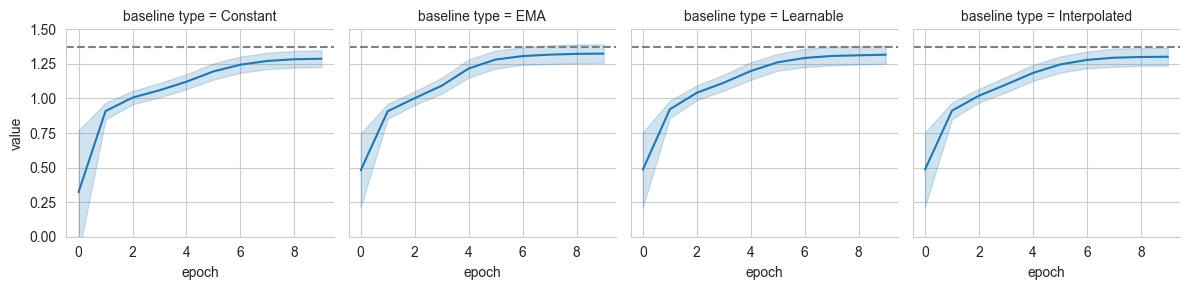

In [8]:
grid = sns.FacetGrid(pd_log[pd_log['name']=='mutual_information'], col='baseline type', ylim=(0,1.5))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.refline(y=true_mi)

## Critic Architectures
The `torch_mist` package includes two main families of critics: `JointCritic` and `SeparableCritic`, which model $f_\theta(x,y)$ directly with a neural network (joint) or as a product of feature extractor networks (separable). The `joint_critic` and `separable_critic` utilities provide a quick way to instantiate critic architectures.
We consider the following critics:

| Critic               | $f_\theta(x,y)$                         |
|----------------------|-----------------------------------------|
| Joint                | $MLP_\theta(x,y)$                       | 
| Separable Asymmetric | $MLP_{\theta_x}(x)^T MLP_{\theta_y}(y)$ |
| Separable Symmetric  | $MLP_\theta(x)^T MLP_\theta(y)$         |
| Separable One-sided  | $MLP_\theta(x)^Ty$                      |


Critic neural architectures can be easily instantiated using the `joint_critic` and `separable_critic` utility functions that require the number of dimensions for $x$ and $y$ and the list of hidden layers. Additional parameters can be used to specify non-linearities and the structure of the critic (`asymmetric`, `symmetric` or `one` for one-sided).

In [9]:
from torch_mist.critic import joint_critic, separable_critic

critics = {}

# Joint critic architecture with GELU activations
critics['Joint'] = joint_critic(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=[64, 64],
    nonlinearity=nn.GELU()
)

# Separable Asymmetric critic architecture
critics['Separable Asymmetric'] = separable_critic(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=[64, 64],
    projection_head='asymmetric',
    nonlinearity=nn.GELU(),
)


It is also possible to specify critic architectures by using the `SeparableCritic` and `JointCritic` classes directly:

In [10]:
from torch_mist.critic import SeparableCritic

# Projection head architecture
projection_head = nn.Sequential(
        nn.Linear(x_dim, 128),
        nn.GELU(),
        nn.Linear(128, 64)
    )

# Separable Symmetric critic architecture
# Note that the same architecture can be instantiated by specifying 
# projection_head='symmetric' and the `separable_critic` factory
critics['Separable Symmetric'] = SeparableCritic(
    f_x=projection_head,
    f_y=projection_head,
)

Alternatively, custom critic architectures can be designed by extending the `Critic`, `SeparableCritic` and `JointCritic` classes.

In [11]:
from torch_mist.critic import SeparableCritic
from pyro.nn import DenseNN


class OneSidedCritic(SeparableCritic):
    def __init__(self, x_dim, y_dim, hidden_dims, nonlinearity=nn.ReLU(True)):
        # pyro utility to easily create a MLP
        f_x = DenseNN(
            input_dim=x_dim, 
            hidden_dims=hidden_dims, 
            nonlinearity=nonlinearity,
            param_dims=[y_dim]
        )
        
        super().__init__(f_x=f_x, f_y=None)

    def forward(
        self,
        x: torch.Tensor,
        y: torch.Tensor,
    ) -> torch.Tensor:
        # Implement custom forward if necessary
        return super().forward(x, y)
    
    
critics['One-sided'] = OneSidedCritic(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=[64, 64],
    nonlinearity=nn.GELU(),
)

In [12]:
for name, critic in critics.items():
    n_params = sum([param.numel() for param in critic.parameters()])
    print(f"{name} critic architecture, {n_params} Parameters")

Joint critic architecture, 4417 Parameters
Separable Asymmetric critic architecture, 8576 Parameters
Separable Symmetric critic architecture, 8512 Parameters
One-sided critic architecture, 4353 Parameters


In [13]:
from torch_mist.estimators import NWJ
from torch_mist.utils import train_mi_estimator

pd_log = pd.DataFrame()

for name, critic in critics.items():
    estimator = NWJ(
        critic=critic,
        neg_samples=32
    )
    
    print(f"Training the {name} critic")
    train_log = train_mi_estimator(
        estimator=estimator,
        x=samples['x'], y=samples['y'],
        **train_parameters           
    )
    train_log['critic type'] = name
    pd_log = pd.concat([pd_log, train_log])

Training the Joint critic


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the Separable Asymmetric critic


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the Separable Symmetric critic


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the One-sided critic


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

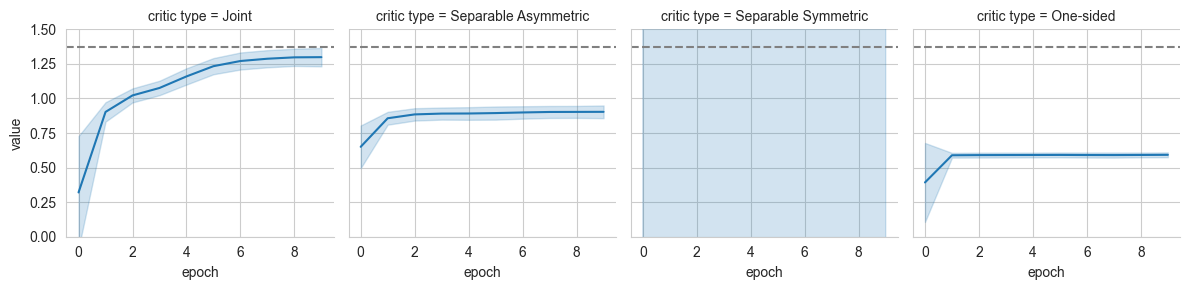

In [14]:
grid = sns.FacetGrid(pd_log[pd_log['name']=='mutual_information'], col='critic type', ylim=(0,1.5))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.refline(y=true_mi)

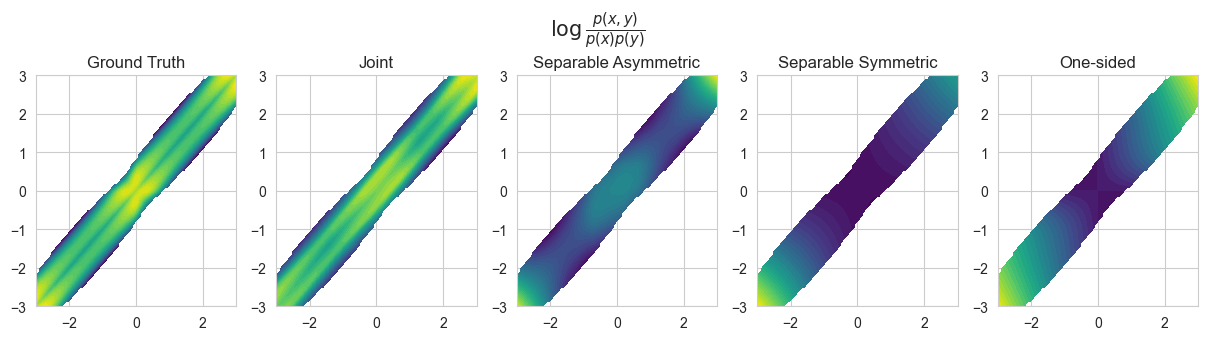

In [15]:
# We create a uniform grid to visualize the functions modeled by the critics
res = 100
x_grid = torch.linspace(-3,3,res).view(-1,1,1)
y_grid = torch.linspace(-3,3, res).view(1,-1,1)
X, Y = np.meshgrid(x_grid, y_grid)

# Compute the true log-ratio log p(x,y)p(x)p(y) on the grid
log_marginal = p_XY.marginal('x').log_prob(x=x_grid) +  p_XY.marginal('y').log_prob(y=y_grid)
log_joint = p_XY.log_prob(x=x_grid, y=y_grid)
# We visualize only the points for which p(x,y) > e^{-20}
mask = (log_joint>-20).data.numpy()
log_ratio = (log_joint - log_marginal).data.numpy()

# Plot the true log-ratio
f, ax = plt.subplots(1,len(critics)+1,figsize=((1+len(critics))*IMG_SIZE, IMG_SIZE))
f.suptitle("$\\log \\frac{p(x,y)}{p(x)p(y)}$", fontsize=15, y=1.1)
ax[0].contourf(X, Y, log_ratio/mask, cmap='viridis', levels=40)
ax[0].set_title('Ground Truth')

# And the unnormalized log-ratio modeled by the critics
for i, (name, critic) in enumerate(critics.items()):
    unnormalized_ratio = critic(x_grid, y_grid).data.numpy()
    ax[i+1].contourf(X, Y, unnormalized_ratio/mask, cmap='viridis', levels=40)
    ax[i+1].set_title(name)

 We can clearly notice how the more constrained architecture struggle to model the log-ratio for the given distribution. This translates into less-tight lower-bounds for $I(x;y)$.

### Number of Negative Samples


We refer to $M$ as `neg_samples` to indicate the number of "negative samples" that are used for each element of the batch. In other words, `neg_samples` regulates how many $y_j$ are used for each $x_i$ in the batch for the estimation of the expectation above.

The value of `neg_samples` is capped by the `batch_size`. A value of `neg_samples=0` is used to specify that the summation over $j$ should go over the whole batch (including $i=j$), negative values are used to specify the number of relative negative samples with respect to the current batch size.
E.g. `neg_samples=-10` will use `batch_size-10` negative samples for each $x_i$ (with a minimum of 1 if the `batch_size` is 10 or less).

Note that the number of negative samples impacts the memory usage, computational cost for training and evaluation, the variance, and convergence speed of the estimators. More negative samples increase the costs but tend to improve the quality of the estimation.

We demonstrate this behaviour by training the simple `NWJ` estimator far various number of `neg_samples` 


In [16]:
# We fix a simple critic architecture
critic = joint_critic(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dims=[64, 64],
)

pd_log = pd.DataFrame()

# Train the estimator with different amounts of negative samples
n_negatives = [1, 4, 16, 64]
for neg_samples in n_negatives:
    estimator = NWJ(
        critic=deepcopy(critic),
        neg_samples=neg_samples
    )
    print(f"Training the MI estimator with {neg_samples} negative sample(s)")
    train_log = train_mi_estimator(
        estimator=estimator,
        x=samples['x'], y=samples['y'],
        **train_parameters           
    )
    train_log['negative samples'] = neg_samples
    pd_log = pd.concat([pd_log, train_log])

Training the MI estimator with 1 negative sample(s)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with 4 negative sample(s)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with 16 negative sample(s)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the MI estimator with 64 negative sample(s)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

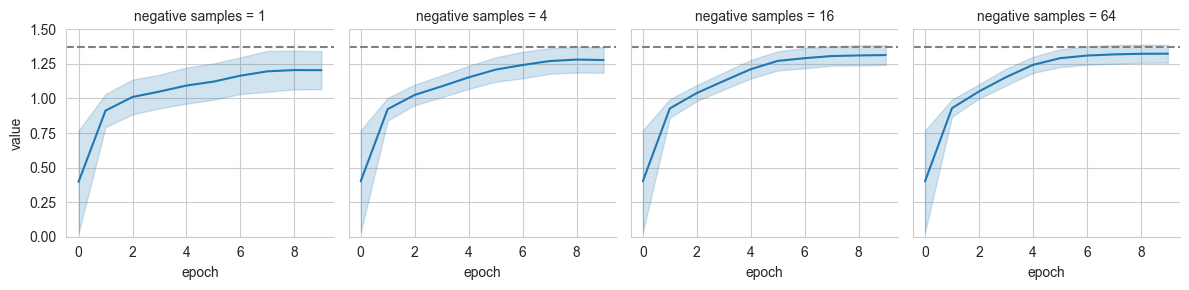

In [17]:
grid = sns.FacetGrid(pd_log[pd_log['name']=='mutual_information'], col='negative samples', ylim=(0,1.5))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.refline(y=true_mi)

## Alternative Training objectives

Estimating the expected log-partition function becomes quite challenging for large values of $I(x;y)$ since the variance of $e^{\hat F(x,y)}$ with respect to the product distribution $p(x)p(y)$ and the optimal energy $\hat F(x,y)$ grows exponentially with $I(x;y)$. One possible work-around involves optimizing the energy $F(x,y)$ to 
maximize the Jensen-Shannon (JS) divergence instead:
$$
JS(p(x,y)||p(x)p(y)) \ge \max_{F} \mathbb{E}_{p(x,y)}[\log \sigma(F(x,y))] + \mathbb{E}_{p(x)p(y)}[\log (1-\sigma(F(x,y)))] + 2\log2.
$$
The optimal energy is given by:
$$
\hat F^{JS}(x,y) = \log\frac{p(x,y)}{p(x)p(y)} + 1
$$
On the other hand, we know that log-ratio between $p(x,y)$ and $p(x)p(y)$ is an optimal critic for the dual KL divergence:
$$
\hat F^{KL}(x,y) = \log\frac{p(x,y)}{p(x)p(y)},
$$
Therefore we can use $\hat F^{KL}(x,y) = \hat F^{JS}(x,y) - 1$ into the dual expression of KL to obtain a MI estimator
$$
I(x;y) =  \mathbb{E}_{p(x,y)}[\hat F^{JS}(x,y)-1] -\mathbb{E}_{p(x)p(y)}[e^{\hat F^{JS}(x,y) - 1}] + 1 = \mathbb{E}_{p(x,y)}[\hat F^{JS}(x,y)] -\mathbb{E}_{p(x)p(y)}[e^{\hat F^{JS}(x,y) - 1}]
$$

As a result, we can optimize $F(x,y)$ using the dual expression for the JS divergence and then use it for the estimation of KL. The training procedure for the dual expression of the JS divergence is generally more stable, but suboptimal critics may result in under-estimation of the true value of MI.

This strategy is used in practice by the `JS` and `SMILE` estimators that use the same baselines as `NWJ` and `MINE` respectively for evaluation. 


In [18]:
from torch_mist.estimators.discriminative import JS, SMILE

pd_log = pd.DataFrame()

estimators = {
    'JS': JS(
        critic = deepcopy(critic),
        neg_samples=32,
    ),
    'SMILE': SMILE(
        critic = deepcopy(critic),
        neg_samples=32,
        # Smile additionally clips the values of F(x,y) into the interval [-\tau, \tau]
        tau=5  
    )
}

# We can train all the estimators
for name, estimator in estimators.items():
    print(f"Training the {name}  MI estimator")
    train_log = train_mi_estimator(
        estimator=estimator,
        x=samples['x'], y=samples['y'],
        **train_parameters           
    )
    train_log['estimator'] = name
    pd_log = pd.concat([pd_log, train_log])

Training the JS  MI estimator


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

Training the SMILE  MI estimator


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/782 [00:00<?, ?it/s]

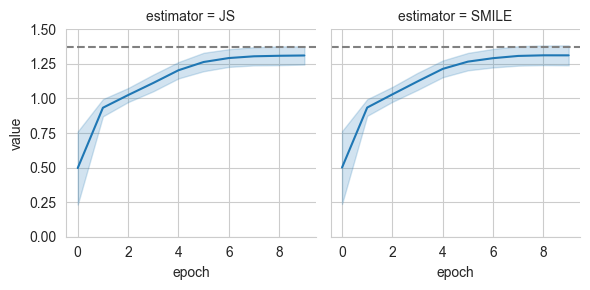

In [19]:
grid = sns.FacetGrid(pd_log[pd_log['name']=='mutual_information'], col='estimator', ylim=(0,1.5))
grid.map(sns.lineplot, 'epoch', 'value', errorbar='sd')
grid.refline(y=true_mi)